# Hidden Markov Model and Maximum Likelihood Estimation 

In this notebook, we will see an implementation of maximum likelihood estimation for Hidden Markov Model (HMM), which is described in Chapter 13 of the book PRML. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Model

### 1.1 Setting

#### Observed variables
* $N \in \mathbb{N}$ : the number of observation data
* $X = (x_0, x_1, \dots, x_{N-1})$ : the set of observation data. All $x_n$ belong to an appropriatespecified set.

#### Latent variables
* $K \in \mathbb{K}$ : the number of latent states
* $Z = (z_0, z_1, \dots, z_{N-1})$ : the set of latent variable. $z_n \in \{ 0,1 \}^K$, and $\sum_{k=0}^{K-1}z_{n,k} = 1$

#### Parameters
* $\pi \in [0,1]^{K}$ : $\pi_k$ stands for the probability that $z_{0,k}=1$. Note that $\sum_{k=0}^{K-1} \pi_k = 1$ holds. 
* $A = \left( A_{j,k} \right)_{j,k = 0,1,\dots, K-1}$ : $A_{j,k} = p(z_{n,k}=1 | z_{n-1,j}=1)$, i.e., $A_{j,k}$ stands for the transition probability from state $j$ to state $k$.
* $\phi = \left( \phi_k \right)_{k=0,1, \dots, K-1}$ : the parameters for emission probability

### 1.2 Model

The joint distribution of $X$ and $Z$ is given by 

$$
\begin{align}
    p\left( X, Z \middle| \theta \right) = 
    p\left( z_0 \middle| \pi \right)
    \left[ \prod_{n=1}^{N-1} p\left( z_n \middle| z_{n-1} , A\right) \right]
    \left[ \prod_{n=0}^{N-1}  p\left( x_n \middle| z_n, \phi \right) \right]
\end{align}
$$

where

$$
\begin{align}
    \theta &= \left( \pi, A, \phi \right) \\
    p\left( z_0 \middle| \pi \right) &= \prod_{k=0}^{K-1} \pi_{k}^{z_{0,k}}  \\
    p\left( z_n \middle| z_{n-1}, A \right) &=  \prod_{k=0}^{K-1} \prod_{j=0}^{K-1} A_{j,k} ^{z_{n-1,j} z_{n,k}} \\
    p\left( x_n \middle| z_n, \phi \right) &= \prod_{k=0}^{K-1} p(x_n | \phi_k)^{z_{n,k}}
\end{align}
$$


## 2. Maximum Likelihood Estimation : EM algorithm

Our goal here is to obtain $\theta$ that maximizes
\begin{align}
    p(X|\theta) = \sum_{Z} p(X,Z|\theta)
\end{align}
Because here we have a latent variable $Z$, we can utilise EM algorithm to perform the maximization. 

### 2.1 EM algorithm

0. input : $\theta_{ini}$, $X$.
1. $\theta^{old} \leftarrow \theta_{ini}$
2. while not converge
    1. E-step : Calculate $Q(\theta, \theta^{old}) := \sum_{Z} p \left( Z \middle| X,\theta^{old} \right) \log p(X,Z|\theta)$ as a function of $\theta$
    2. M-step : Let $\theta_M$ be $\theta$ that maximizes $Q(\theta, \theta^{old})$, and set $\theta^{old} \leftarrow \theta_M$

### 2.2 E-step

The function $Q(\theta, \theta^{old})$ is given by

$$
\begin{align}
    Q(\theta, \theta^{old}) &= 
    \sum_{k=0}^{K-1} \gamma_{0,k} \log \pi_k 
    {} + \sum_{n=1}^{N-1} \sum_{j,k=0}^{K-1} \xi_{n,j,k} \log A_{j,k} 
    {} + \sum_{n=0}^{N-1} \sum_{k=0}^{K-1} \gamma_{n,k} \log p(x_n | \phi_k) \\
    \gamma_{n,k} &:= p(z_{n,k}=1 | X, \theta^{old}) \\
    \xi_{n,j,k} &:= p(z_{n-1,j}=1 , z_{n,k}=1 | X, \theta^{old})
\end{align}
$$

The quantities $\gamma$ and $\xi$ can be obtained as follows (See Sections 13.2.2 and 13.2.4 of the book.)

$$
\begin{align}
    \gamma_{n,k} &=  \hat{\alpha}_{n,k} \hat{\beta}_{n,k} \\
    \hat{\alpha}_{n,k} &:= p(z_{n,k}=1 | x_1, \dots, x_n ) \\
    \hat{\beta}_{n,k} &:= \frac{p(x_{n+1}, \dots, x_N | z_{n,k} = 1)}{ p(x_{n+1}, \dots, x_N | x_1, \dots, x_n) } \ \ (n= 0, 1, \dots, N-2) \\
    \hat{\beta}_{N-1,k} &:= 1 \\
    \xi_{n,j,k} &= \frac{1}{c_n} \hat{\alpha}_{n-1,j} p(x_n|\phi_k) A_{j,k} \hat{\beta}_{n,k}
\end{align}
$$

where $\alpha$ and $\beta$ can be calculated recursively : 

$$
\begin{align}
    c_n \hat\alpha_{n,k} &= p(x_n | \phi_k) \sum_{j=0}^{K-1} \hat\alpha_{n-1,j} A_{j,k}^{old} \\
    \hat\alpha_{0,k} &= \frac{\pi_k p(x_0 | \phi_k)}{ \sum_{j=0}^{K-1}\pi_k p(x_0 | \phi_k) } \\
    c_{n+1} \hat\beta_{n,k} &= \sum_{j=1}^{K-1} \hat\beta_{n+1,j} p(x_{n+1}|\phi_j) A_{k,j}^{old} \\
    \hat\beta_{N-1,k} &= 1
\end{align}
$$

Note that $c_n$ can be obtained as a normalization constant of $\alpha$. 

### 2.3 M-step

$$
\begin{align}
    \pi_k &= \frac{\gamma_{0,k}}{\sum_{j=0}^{K-1} \gamma_{0,j}} \\
    A_{j,k} &= \frac{ \sum_{n=1}^{N-1} \xi_{n,j,k} }{  \sum_{n=1}^{N-1} \sum_{l=0}^{K-1} \xi_{n,j,l}  }
\end{align}
$$

The maximization w.r.t. $\phi$ depends on the specific form of emission probability.

## 3. From math to code

### 3.1 Emission probability

For specificity, here we consider the case where the emission probability is a Bernoulli distribution: 

$$
\begin{align}
    p(x|\phi_k) = \phi_{k}^{x} \left( 1 - \phi_{k} \right)^{1-x} 
\end{align}
$$

with $x \in \{ 0,1 \}$ and $\phi_k \in [0,1]$.

For this emissoin probability, we have, in M-step

$$
\begin{align}
    \phi_k = \frac{ \sum_{n=0}^{N-1} \gamma_{n,k} x_n }{ \sum_{n=0}^{N-1} \gamma_{n,k}}
\end{align}
$$

### 3.2 Arrays
* pi : (K,) array. pi[k] = $\pi_k$
* A : (K,K) array. A[j,k] = $A_{j,k}$.
* phi : (K,) array. 

* Pmat : (N,K) array, Pmat[n,k] = $p(x_n|\phi_k)$
* gamma : (N,K) array. gamma[n,k] = $\gamma_{n,k}$
* alpha : (N,K) array. alpha[n,k] = $\hat\alpha_{n,k}$
* beta : (N,K) array. beta[n,k] = $\hat\beta_{n,k}$

### 3.3 Code

In [2]:
class HMM:
    def __init__(self, K):
        self.K = K
        
        self.pi = None
        self.A = None
        self.phi = None
                    
    
    # emissoin probability dependent part
    def calc_Pmat(self):
        '''
        Calculate Pmat (p (x_n | \phi_k)) for E step. 
        '''
        self.Pmat = np.zeros((self.N, self.K))
        for k in range(self.K):
            tmp = self.phi[k]
            self.Pmat[:,k] = (tmp**self.X)*((1-tmp)**(1-self.X))
    def calc_phi(self):
        '''
        M step calculation for emission probability parameter phi
        '''
        self.phi = (self.gamma.T @ self.X)  / np.sum(self.gamma, axis=0)
    def init_phi(self):
        '''
        initialize the parameter phi
        '''
        self.phi = np.random.random(self.K)
    

    # initialization
    def load_dat(self, X):
        self.X = X
        self.N = len(X)
    def init_params(self):
        self.init_phi()
        tmp = np.random.random(self.K)
        self.pi =  tmp / np.sum(tmp)
        tmp = np.random.random((self.K, self.K))
        self.A = tmp / np.reshape( np.sum(tmp, axis=1) , (self.K, 1))

    
    # E step
    def forward(self):
        '''
        Calculate alpha by recursion
        '''
        self.alpha = np.zeros((self.N, self.K))
        self.c = np.ones(self.N)
        tmp = self.pi*self.Pmat[0]
        self.alpha[0] = tmp / np.sum(tmp)
        for n in range(1,self.N,1):
            tmp = self.Pmat[n]*( (self.A).T @  self.alpha[n-1] )
            self.c[n] = np.sum(tmp)
            self.alpha[n] = tmp / self.c[n]
    def backward(self):
        '''
        Calculate beta by recursion
        '''
        self.beta = np.zeros((self.N, self.K))
        self.beta[self.N - 1] = np.ones(self.K)
        for n in range(self.N-2,-1,-1):
            self.beta[n] = self.A @ ( self.beta[n+1]*self.Pmat[n+1] ) / self.c[n+1]
    def estep(self):
        self.calc_Pmat()
        self.forward()
        self.backward()        
        # calculate gamma
        self.gamma = self.alpha*self.beta
        # calculate xi. 
        self.xi = np.einsum( "nj,nk->njk", np.roll(self.alpha,shift=1,axis=0), self.Pmat ) * np.einsum("jk,nk->njk",self.A, self.beta) /np.reshape( self.c, (self.N, 1,1))
        
    
    # M step
    def mstep(self):
        self.pi = self.gamma[0]/np.sum(self.gamma[0])
        xitmp = np.sum(self.xi[1:], axis=0)
        self.A = xitmp / np.reshape(np.sum(xitmp, axis=1) , (self.K, 1))
        # calculate phi
        self.calc_phi()

        
    def fit(self,X, tol=1e-6):
        self.load_dat(X)
        self.init_params()
        
        cnt = 0
        while True:
            A = np.copy(self.A)
            pi = np.copy(self.pi)
            phi = np.copy(self.phi)
            
            self.estep()
            self.mstep()
            cnt += 1
            
            err = np.linalg.norm(A - self.A)**2 + np.linalg.norm(pi - self.pi)**2 + np.linalg.norm(phi - self.phi)**2 
            if err < tol:
                break
        print(cnt)

## 4. Experiment

For illustration, we consider a toy data, which is generated from a two-state coin. 
In state $j$, the probability of getting head is $\mu_j$. 
After each coin toss, the coin can change its state stochastically. 

In [3]:
N = 200 # the number of data

# Here we consider a heavily biased coin.
mu0 = 0.1 
mu1 = 0.9

tp = 0.05 # transition probability

X = np.zeros(N)
Z = np.zeros(N)
z = False
for n in range(N):
    Z[n] = int(z)
    tmp =  np.random.random()
    if tmp < mu0*(not(z)) + mu1*z:
        X[n] = 1.0
    tmp = np.random.random()
    if tmp < tp:
        z = not(z)

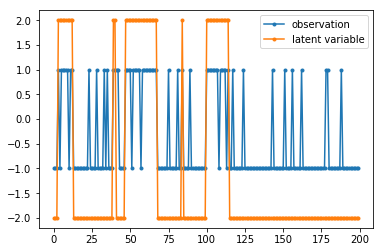

In [4]:
plt.plot(2*X-1,'.-',label='observation')
plt.plot(4*Z-2,'.-',label='latent variable')
plt.legend()
plt.show()

In [5]:
hmm = HMM(K=2)
hmm.fit(X)

13


In [6]:
def printparams(hmm):
    print(f"pi = {hmm.pi}")
    print(f"A = {hmm.A}")
    print(f"phi = {hmm.phi}")
    print("==========") 
printparams(hmm)

pi = [  9.05347383e-12   1.00000000e+00]
A = [[ 0.90026184  0.09973816]
 [ 0.03228069  0.96771931]]
phi = [ 0.86828411  0.12408299]


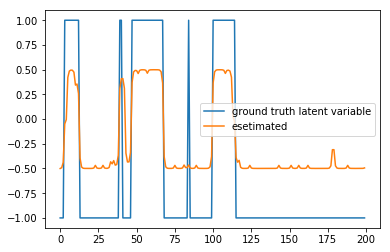

In [8]:
plt.plot(2*Z-1, label='ground truth latent variable')
plt.plot(hmm.gamma[:,0]-0.5, label='esetimated')
plt.legend()